In [4]:
import os
import glob
import itertools
import json
import importlib
import cv2
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import _pickle as pkl
import statsmodels.api as sm


In [5]:
%matplotlib notebook

In [8]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr

In [9]:

#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)


# Load source data

In [10]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])
all_cell_counts = CELLS[['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
             datakey  cell
visual_area               
Li              2599  2599
Lm              3491  3491
V1              4007  4007


# Get RF outdirs

In [11]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

response_type='dff'
traceid = 'traces001'

fit_thr=0.5
do_spherical_correction=False

In [12]:
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001_fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [15]:
# Output dir for Spherical Correction analysis/examples
sphr_dir = os.path.join(aggregate_dir, 'receptive-fields', 'spherical_correction')
if not os.path.exists(sphr_dir):
    os.makedirs(sphr_dir)
print(sphr_dir)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/spherical_correction


In [16]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2
import copy


In [326]:
    levels1 = range(int(np.floor(np.nanmin(cart_x_ds) / interval) * interval),
                    int((np.ceil(np.nanmax(cart_x_ds) / interval) + 2) * interval), 
                    interval)
    list(levels1)

[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60]

In [343]:
def plot_corrected_positions(rfmap_o, rfmap_w, 
                     cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, label=True,
                     c1='m', c2='m', label1='Linear Map', label2='Spherical Map',
                     col_vals=None, row_vals=None, interval=10, inline=1,
                     lw=0.5, cmap='bone', fontsize=12):
    '''
    Takes as input, orignal and corrected rf maps in POSITION coords (nx, ny)
    and plots with overlaid isocontour lines showing DEGREES of monitor.
    '''
    mapcorX, mapcorY = np.meshgrid(range(len(col_vals)), range(len(row_vals)))
    fig, axn = pl.subplots(1,2, figsize=(8, 4))
    fig.suptitle('Remap monitor', fontsize=14, fontweight='bold')
    
    ax = axn[0]
    ax.set_title('%s (deg)' % label1)
    currfig = ax.imshow(cart_x_ds, alpha=0.0)
    levels1 = range(int(np.floor(np.nanmin(cart_x_ds) / interval) * interval),
                    int((np.ceil(np.nanmax(cart_x_ds) / interval) + 2) * interval), 
                    interval)
    im1 = ax.contour(mapcorX, mapcorY, cart_x_ds, levels1, colors=c1, linewidth=lw)
    if label:
        ax.clabel(im1, fontsize=fontsize, inline=inline, fmt='%2.1f')
    currfig = ax.imshow(cart_y_ds, alpha=0.0)
    levels2 = range(int(np.floor( np.nanmin(cart_y_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(cart_y_ds) / interval) + 2) * interval), interval)
    im2 = ax.contour(mapcorX, mapcorY, cart_y_ds, levels2, colors=c2, linewidth=lw)
    if label:
        ax.clabel(im2, fontsize=fontsize, inline=inline, fmt='%2.1f')
    ax.imshow(rfmap_o, cmap=cmap)
    
    ax=axn[1]
    ax.set_title('%s (deg)' % label2)
    deg_x_ds = np.rad2deg(sphr_x_ds)
    currfig = ax.imshow(deg_x_ds, alpha=0.)
    levels3 = range(int(np.floor( np.nanmin(deg_x_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_x_ds) / interval) + 1) * interval), interval)
    im3 = ax.contour(mapcorX, mapcorY, deg_x_ds, levels3, colors=c1, linewidth=lw)
    if label:
        ax.clabel(im3, fontsize=fontsize, inline=inline, fmt='%2.1f')

    deg_y_ds = np.rad2deg(sphr_y_ds)
    currfig = ax.imshow(deg_y_ds, alpha=0.0)
    levels4 = range(int(np.floor( np.nanmin(deg_y_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_y_ds) / interval) + 1) * interval), interval)
    im4 = ax.contour(mapcorX, mapcorY, deg_y_ds, levels4, colors=c2, linewidth=lw)
    if label:
        ax.clabel(im4, fontsize=fontsize, inline=inline, fmt='%2.1f')
    ax.imshow(rfmap_w, cmap=cmap)

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig

In [339]:
def plot_isolines(lin_coord_x, lin_coord_y, deg_coord_x, deg_coord_y, cmap='viridis',
                interval=10, fontsize=12, inline=1, c1='magenta', c2='green', lw=1,
                manual_x=None, manual_y=None,rightside_up=True,
                resolution=[1080, 1920], mapcorX=None, mapcorY=None,
                fig=None, label1='Linear Map', label2='Spherical Map',
                image1=None, image2=None, image_cmap='gray',
                figtitle='Remap Monitor'):
    '''
    Takes cartesian (lin_coord) and spherical (deg_coord) arrays in PIXEL space 
    and draws isocontour liens on top in DEGREES of monitor. 
    Provide image1, image2 to also overlay an image (e.g., checkerboard, rf map).
    '''
    if mapcorX is None or mapcorY is None:
        mapcorX, mapcorY = np.meshgrid(range(resolution[1]), range(resolution[0]))
    
    if fig is None:
        fig, axn = pl.subplots(1,2,figsize=(8, 4))
    else:
        axn = fig.axes
        
    fig.suptitle(figtitle, fontsize=14, fontweight='bold')
    # plot x-coords
    ax = axn[0] #pl.subplot(221)
    ax.set_title('%s (deg.)' % label1)
    ax.imshow(lin_coord_x, cmap=cmap, alpha=0)
    levels1 = range(int(np.floor(np.nanmin(lin_coord_x) / interval) * interval),
                    int((np.ceil(np.nanmax(lin_coord_x) / interval) + 2) * interval), interval)
    im1 = ax.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors=c1, linewidth=lw)
    if manual_x is not None:
        ax.clabel(im1, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 manual=manual_y, rightside_up=rightside_up)
    else:
        ax.clabel(im1, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 rightside_up=rightside_up)
    # plot y-coords
    ax.imshow(lin_coord_y, cmap=cmap, alpha=0)
    levels2 = range(int(np.floor( np.nanmin(lin_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(lin_coord_y) / interval) + 2) * interval), interval)
    im2 = ax.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors=c2, linewidth=lw)
    if manual_y is not None:
        ax.clabel(im2, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 manual=manual_y, rightside_up=rightside_up)
    else:
        ax.clabel(im2, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 rightside_up=rightside_up)
    if image1 is not None:
        ax.imshow(image1, alpha=0.5, cmap=image_cmap)
    
    ax = axn[1] #pl.subplot(222)
    ax.set_title('%s (deg)' % label2)
    ax.imshow(deg_coord_x, cmap=cmap, alpha=0)
    levels3 = range(int(np.floor( np.nanmin(deg_coord_x) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_x) / interval) + 1) * interval), interval)
    im3 = ax.contour(mapcorX, mapcorY, deg_coord_x, levels3, colors=c1, linewidth=lw)
    if manual_x is not None:
        ax.clabel(im3, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 manual=manual_x, rightside_up=rightside_up)
    else:
        ax.clabel(im3, fontsize=fontsize, inline=inline, fmt='%2.1f', 
                  rightside_up=rightside_up)
        
    ax.imshow(deg_coord_y, cmap=cmap,alpha=0)
    levels4 = range(int(np.floor( np.nanmin(deg_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_y) / interval) + 1) * interval), interval)
    im4 = ax.contour(mapcorX, mapcorY, deg_coord_y, levels4, colors=c2, linewidth=lw)
    if manual_y is not None:
        ax.clabel(im4, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 manual=manual_y, rightside_up=rightside_up)
    else:
        ax.clabel(im4, fontsize=fontsize, inline=inline, fmt='%2.1f',
                 rightside_up=rightside_up)
    if image2 is not None:
        ax.imshow(image2, alpha=0.5, cmap=image_cmap)
        
    for ax in axn:
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
        
    return fig

In [29]:
datakey='20190522_JC084_fov1'

fit_results, fit_params = rfutils.load_fit_results(datakey, experiment='rfs',
                                    traceid=traceid, response_type=response_type,
                                    do_spherical_correction=False)

fit_params['screen']['resolution']

[1920, 1080]

In [298]:
fit_params['row_vals']

[-25.0, -20.0, -15.0, -10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0, 25.0]

In [300]:
np.linspace(-50, 50, 11)

array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.])

In [301]:
ncols = 11 #len(fit_params['col_vals']) #21
nrows = 6 #len(fit_params['row_vals']) #11
row_vals = np.linspace(-25, 25, nrows)
col_vals = np.linspace(-50, 50, ncols)

resolution = [1920, 1080] # fit_params['screen']['resolution']

# Downsample screen (don't need full resolution)
downsampler=3 #fit_params_sphr['downsample_factor']
resolution_ds = [int(i/downsampler) for i \
                 in resolution[::-1]]
print("Screen resolution (ds=%.1fx): [%i, %i]" \
      % (downsampler, resolution_ds[0], resolution_ds[1]))
# Linear coordinates
lin_x, lin_y = rfutils.get_lin_coords(resolution=resolution_ds)
# Spherical coordinates (Lin coords already in deg)
cart_x_wlin, cart_y_wlin, sphr_x_wlin, sphr_y_wlin = rfutils.get_spherical_coords(cart_pointsX=lin_x, 
                                        cart_pointsY=lin_y, cm_to_degrees=False)
# cart_x.shape
cart_x_none, cart_y_none, sphr_x_none, sphr_y_none = rfutils.get_spherical_coords(cart_pointsX=None, 
                                        cart_pointsY=None, cm_to_degrees=True,
                                        resolution=resolution_ds) 

Screen resolution (ds=3.0x): [360, 640]
(360, 640) (360, 640)


#### Direct compare methods

In [302]:
print("Cart x min/max: %.2f, %.2f" % (cart_x_wlin.min(), cart_x_wlin.max()))
print("Cart y min/max: %.2f, %.2f" % (cart_y_wlin.min(), cart_y_wlin.max()))

print("Cart x_none min/max: %.2f, %.2f" % (cart_x_none.min(), cart_x_none.max()))
print("Cart y_none min/max: %.2f, %.2f" % (cart_y_none.min(), cart_y_none.max()))


Cart x min/max: -59.70, 59.70
Cart y min/max: -33.60, 33.60
Cart x_none min/max: -59.70, 59.70
Cart y_none min/max: -33.60, 33.60


In [303]:
corr_x_wlin, corr_y_wlin = np.rad2deg(sphr_x_wlin), np.rad2deg(sphr_y_wlin)

print("Corrected x min/max: %.2f, %.2f" % (cart_x_wlin.min(), cart_x_wlin.max()))
print("Corrected y min/max: %.2f, %.2f" % (cart_y_wlin.min(), cart_y_wlin.max()))

corr_x_none, corr_y_none = np.rad2deg(sphr_x_none), np.rad2deg(sphr_y_none)
print("Corrected x_none min/max: %.2f, %.2f" % (corr_x_none.min(), corr_x_none.max()))
print("Corrected y_none min/max: %.2f, %.2f" % (corr_y_none.min(), corr_y_none.max()))


Corrected x min/max: -59.70, 59.70
Corrected y min/max: -33.60, 33.60
Corrected x_none min/max: -50.98, 50.98
Corrected y_none min/max: -34.78, 34.78


In [304]:
checkers = checkerboard((nrows, ncols))
checkmap = copy.copy(checkers)
screen_bounds_pix = rfutils.get_screen_lim_pixels(cart_x, cart_y,
                                        row_vals=row_vals, col_vals=col_vals)
(pix_bottom_edge, pix_left_edge, pix_top_edge, pix_right_edge) = screen_bounds_pix

def get_transformed_images(checkmap, cart_x, cart_y, 
                           sphr_x, sphr_y,
                          row_vals, col_vals, resolution):
    # Upsample RF map to screen pixels
    check_orig = rfutils.resample_map(checkmap, cart_x, cart_y, 
                              row_vals=row_vals, col_vals=col_vals,
                              resolution=resolution)
    # Warp resampled RF map
    check_sphr = rfutils.warp_spherical(check_orig, 
                                sphr_x, sphr_y, cart_x, cart_y, 
                                normalize_range=True, method='linear')
    # "perceived" (uncorrected) rfmap array
    warp_x = rfutils.warp_spherical(cart_x, cart_x, cart_y, 
                                     sphr_x, sphr_y, normalize_range=True)
    warp_y = rfutils.warp_spherical(cart_y, cart_x, cart_y, 
                                         sphr_x, sphr_y, normalize_range=True)

    # Warp resampled RF map
    check_warp = rfutils.warp_spherical(check_orig, 
                                cart_x, cart_y, sphr_x, sphr_y, 
                                normalize_range=True, method='linear')
    return check_orig, check_sphr, check_warp

In [305]:
check_orig, check_sphr, check_warp = get_transformed_images(checkmap, 
                                            cart_x_wlin, cart_y_wlin, 
                                            sphr_x_wlin, sphr_y_wlin,
                                            row_vals, col_vals, resolution_ds)

In [306]:
check_orig_none, check_sphr_none, check_warp_none = get_transformed_images(checkmap, 
                                            cart_x_none, cart_y_none, 
                                            sphr_x_none, sphr_y_none,
                                            row_vals, col_vals, resolution_ds)

<IPython.core.display.Javascript object>


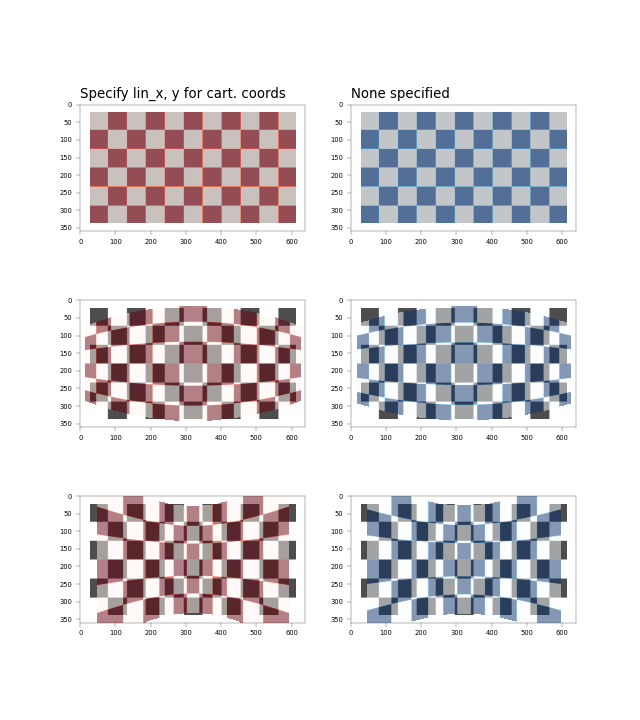

In [355]:
fig, axn = pl.subplots(3,2, figsize=(8,9))
for ax in axn.flat:
    ax.imshow(check_orig, cmap='gray', vmin=0, vmax=1, alpha=0.7)
ax=axn[0,0]
ax.imshow(check_orig, cmap='Reds', vmin=0, vmax=1, alpha=0.7, label='specify_lin')
ax.set_title('Specify lin_x, y for cart. coords', loc='left', fontsize=12)
ax=axn[0,1]
ax.imshow(check_orig_none, cmap='Blues', vmin=0, vmax=1, alpha=0.7, label='None-lin')
ax.set_title('None specified', loc='left', fontsize=12)

ax=axn[1,0]
ax.imshow(check_warp, cmap='Reds', vmin=0, vmax=1, alpha=0.5)
ax.set_title('Specify lin_x, y for cart. coords', loc='left', fontsize=12)

ax=axn[1,1]
ax.imshow(check_warp_none, cmap='Blues', vmin=0, vmax=1, alpha=0.5)

ax=axn[2,0]
ax.imshow(check_sphr, cmap='Reds', vmin=0, vmax=1, alpha=0.5)
ax=axn[2,1]
ax.imshow(check_sphr_none, cmap='Blues', vmin=0, vmax=1, alpha=0.5)


<IPython.core.display.Javascript object>


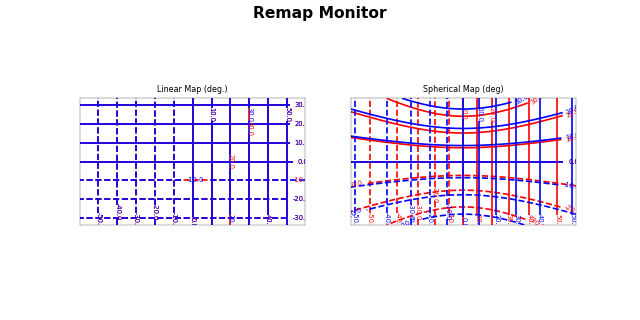

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [333]:
fig = plot_isolines(cart_x_wlin, cart_y_wlin, corr_x_wlin, corr_y_wlin, 
            cmap='Spectral', c1='red', c2='red',
          resolution=resolution_ds, manual_x=None, manual_y=None,
          rightside_up=True, interval=10, fontsize=6 )
fig.suptitle('')

fig = plot_isolines(cart_x_none, cart_y_none, corr_x_none, corr_y_none, 
            cmap='Spectral', c1='blue', c2='blue', fig=fig,
          resolution=resolution_ds, manual_x=None, manual_y=None,
          rightside_up=True, interval=10, fontsize=6 )

In [356]:
resolution_ds

[360, 640]

In [334]:
def to_positions(check_orig, check_sphr, cart_x, cart_y, sphr_x, sphr_y, 
                row_vals, col_vals):
    screen_bounds_pix = rfutils.get_screen_lim_pixels(cart_x, cart_y,
                                            row_vals=row_vals, col_vals=col_vals)
    (pix_bottom_edge, pix_left_edge, pix_top_edge, pix_right_edge) = screen_bounds_pix

    # Downsample, so we don't have repeated values
    check_trim  = rfutils.trim_resampled_map(check_orig, screen_bounds_pix)
    check_trim_c = rfutils.trim_resampled_map(check_sphr, screen_bounds_pix)
    check_o = cv2.resize(check_trim, (len(col_vals), len(row_vals)))
    check_c = cv2.resize(check_trim_c, (len(col_vals), len(row_vals)))
    # Get downsampled coordinates
    # Trim and downsample coordinate space to match corrected map
    cart_x_ds  = cv2.resize(cart_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
    cart_y_ds  = cv2.resize(cart_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

    sphr_x_ds  = cv2.resize(sphr_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
    sphr_y_ds  = cv2.resize(sphr_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))
    
    return check_o, check_c, cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds

In [335]:
check_, check_c, cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds = to_positions(
                                            check_orig, check_sphr,
                                            cart_x, cart_y, 
                                            sphr_x, sphr_y, row_vals, col_vals)
check_none, check_c_none, cart_x_ds_none, cart_y_ds_none, sphr_x_ds_none, sphr_y_ds_none = to_positions(
                                            check_orig_none, check_sphr_none,
                                            cart_x_none, cart_y_none, 
                                            sphr_x_none, sphr_y_none,
                                            row_vals, col_vals)

<IPython.core.display.Javascript object>


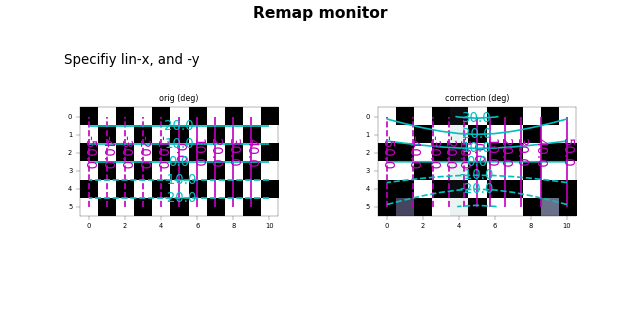

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.1, 0.8, 'Specifiy lin-x, and -y')

In [350]:
fig = plot_corrected_positions(check_, check_c, 
                    cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, 
                    col_vals=col_vals, row_vals=row_vals, interval=10,
                    fontsize=12, inline=False, label=True,
                    c1='m', c2='c', label1='orig', label2='correction')

fig.text(0.1, 0.8, 'Specifiy lin-x, and -y', fontsize=12)


<IPython.core.display.Javascript object>


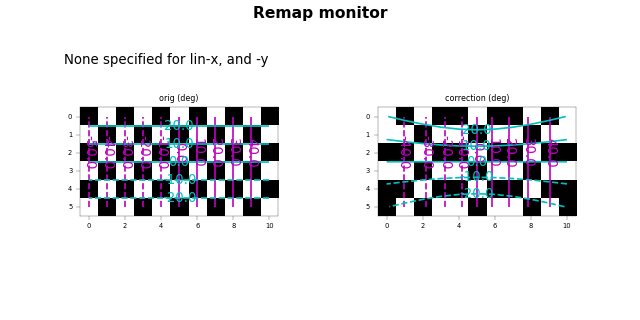

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.1, 0.8, 'None specified for lin-x, and -y')

In [352]:
fig = plot_corrected_positions(check_none, check_c_none, 
                    cart_x_ds_none, cart_y_ds_none, sphr_x_ds_none, sphr_y_ds_none, 
                    col_vals=col_vals, row_vals=row_vals, interval=10,
                    fontsize=12, inline=False, label=True,
                    c1='m', c2='c', label1='orig', label2='correction')
fig.text(0.1, 0.8, 'None specified for lin-x, and -y', fontsize=12)


In [321]:
levels1 = range(int(np.floor(np.nanmin(cart_x_ds) / interval) * interval),
                int((np.ceil(np.nanmax(cart_x_ds) / interval) + 1) * interval), 
                interval)
levels1

range(-60, 60, 10)

In [246]:
checkers = checkerboard((nrows, ncols))
checkmap = copy.copy(checkers)
screen_bounds_pix = rfutils.get_screen_lim_pixels(cart_x, cart_y,
                                        row_vals=row_vals, col_vals=col_vals)
(pix_bottom_edge, pix_left_edge, pix_top_edge, pix_right_edge) = screen_bounds_pix

# Upsample RF map to screen pixels
check_orig = rfutils.resample_map(checkmap, cart_x, cart_y, 
                          row_vals=row_vals, col_vals=col_vals,
                          resolution=resolution_ds)
# Warp resampled RF map
check_sphr = rfutils.warp_spherical(check_orig, 
                            sphr_x, sphr_y, cart_x, cart_y, 
                            normalize_range=True, method='linear')
# Trim
check_trim  = rfutils.trim_resampled_map(check_orig, screen_bounds_pix)
check_trim_sphr  = rfutils.trim_resampled_map(check_sphr, screen_bounds_pix)

# Downsample, so we don't have repeated values
check_o = cv2.resize(check_trim, (ncols, nrows))
check_c = cv2.resize(check_trim_sphr, (ncols, nrows))
# Get downsampled coordinates
# Trim and downsample coordinate space to match corrected map
cart_x_ds  = cv2.resize(cart_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
cart_y_ds  = cv2.resize(cart_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

sphr_x_ds  = cv2.resize(sphr_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
sphr_y_ds  = cv2.resize(sphr_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

<IPython.core.display.Javascript object>


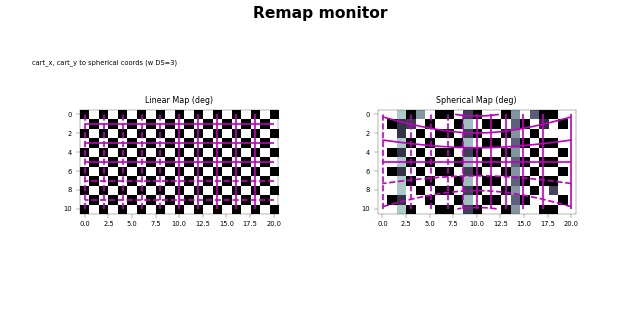

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [247]:
fig = plot_corrected_positions(check_o, check_c, 
                    cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, 
                    col_vals=col_vals, row_vals=row_vals, interval=10,
                    fontsize=12, inline=False, label=False)
fig.text(0.05, 0.8, 'cart_x, cart_y to spherical coords (w DS=3)')
figname = 'gridlines__cart2sphr_%s' % rf_type
# pl.savefig(os.path.join(sphr_dir, '%s.svg' % figname))

In [248]:
print("CART coords x min/max: %.2f, %.2f" %(cart_x_ds.min(), cart_x_ds.max()))
print("CART coords y min/max: %.2f, %.2f" %(cart_y_ds.min(), cart_y_ds.max()))
corr_x_ds = np.rad2deg(sphr_x_ds)
corr_y_ds = np.rad2deg(sphr_y_ds)
print("SPHR coords x min/max: %.2f, %.2f" %(corr_x_ds.min(), corr_x_ds.max()))
print("SPHR coords y min/max: %.2f, %.2f" %(corr_y_ds.min(), corr_y_ds.max()))


CART coords x min/max: -50.01, 49.82
CART coords y min/max: -24.84, 25.02
SPHR coords x min/max: -50.16, 50.06
SPHR coords y min/max: -30.76, 30.95


<IPython.core.display.Javascript object>


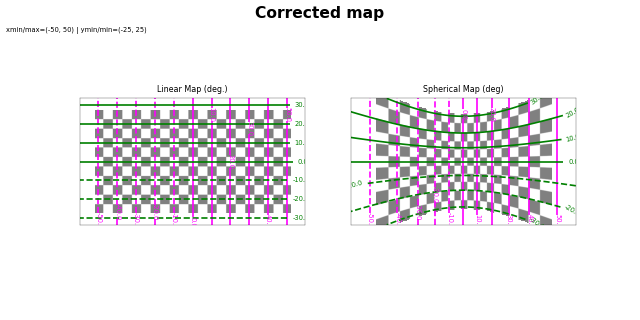

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.01, 0.9, 'xmin/max=(-50, 50) | ymin/min=(-25, 25)')

In [249]:
corrected_x, corrected_y = np.rad2deg(sphr_x), np.rad2deg(sphr_y)
image1 = check_orig*100 - 50
image2 = check_sphr*100 - 50

fig = plot_isolines(cart_x, cart_y, corrected_x, corrected_y, cmap='Spectral',
            resolution=resolution_ds, manual_x=None, manual_y=None,
            rightside_up=True, interval=10, fontsize=6, 
            image1=image1, image2=image2, figtitle='Corrected map')

fig.text(0.01, 0.9, 'xmin/max=(%i, %i) | ymin/min=(%i, %i)' \
        % (np.min(col_vals), np.max(col_vals), np.min(row_vals), np.max(row_vals)))

In [250]:
# "perceived" (uncorrected) rfmap array
warp_x = rfutils.warp_spherical(cart_x, cart_x, cart_y, 
                                 sphr_x, sphr_y, normalize_range=True)
warp_y = rfutils.warp_spherical(cart_y, cart_x, cart_y, 
                                     sphr_x, sphr_y, normalize_range=True)

# Warp resampled RF map
check_warp = rfutils.warp_spherical(check_orig, 
                            cart_x, cart_y, sphr_x, sphr_y, 
                            normalize_range=True, method='linear')

<IPython.core.display.Javascript object>


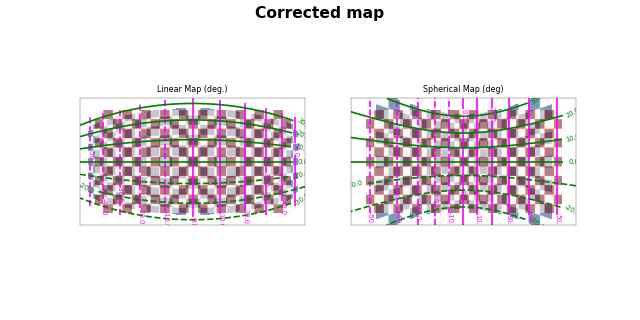

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [251]:

fig = plot_isolines(warp_x, warp_y, corrected_x, corrected_y, cmap='Spectral',
            resolution=resolution_ds, manual_x=None, manual_y=None,
            rightside_up=True, interval=10, fontsize=6, image_cmap='Blues',
            image1=check_warp, image2=image2, figtitle='Corrected map')
fig.axes[0].imshow(check_orig, alpha=0.5, cmap='Reds')
fig.axes[1].imshow(check_orig, alpha=0.5, cmap='Reds')

In [252]:
# Warp resampled RF map
check_corrected = rfutils.warp_spherical(check_warp, 
                            sphr_x, sphr_y, cart_x, cart_y, 
                            normalize_range=True, method='linear')
# Trim
check_trim_corr  = rfutils.trim_resampled_map(check_corrected, screen_bounds_pix)

# Downsample, so we don't have repeated values
check_cc = cv2.resize(check_trim_corr, (ncols, nrows))
check_cc.shape
# # Get downsampled coordinates
# # Trim and downsample coordinate space to match corrected map
# cart_x_ds  = cv2.resize(cart_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
# cart_y_ds  = cv2.resize(cart_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

# sphr_x_ds  = cv2.resize(sphr_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
# sphr_y_ds  = cv2.resize(sphr_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

(11, 21)

In [253]:
print("Perceived, x-min/max: %.2f, %.2f" % (np.nanmin(warp_x), np.nanmax(warp_x)))
print("Perceived, y-min/max: %.2f, %.2f" % (np.nanmin(warp_y), np.nanmax(warp_y)))


Perceived, x-min/max: -59.70, 59.70
Perceived, y-min/max: -33.60, 33.60


<IPython.core.display.Javascript object>


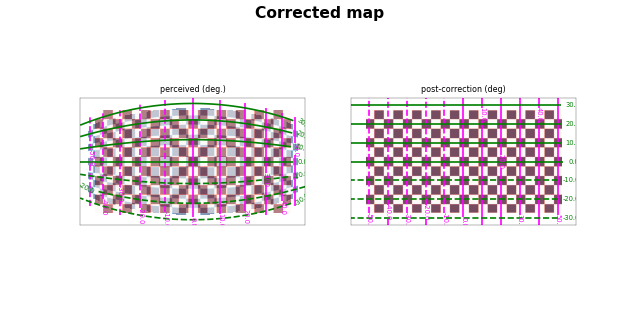

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [254]:

fig = plot_isolines(warp_x, warp_y, cart_x, cart_y, cmap='Spectral',
            resolution=resolution_ds, manual_x=None, manual_y=None,
            rightside_up=True, interval=10, fontsize=6, image_cmap='Blues',
            label1='perceived', label2='post-correction',
            image1=check_warp, image2=check_corrected, figtitle='Corrected map')
fig.axes[0].imshow(check_orig, alpha=0.5, cmap='Reds')
fig.axes[1].imshow(check_orig, alpha=0.5, cmap='Reds')

In [255]:
def plot_remap(lin_coord_x, lin_coord_y, deg_coord_x, deg_coord_y, cmap='viridis',
               interval=10,
               resolution=[1080, 1920], mapcorX=None, mapcorY=None):
    
    if mapcorX is None or mapcorY is None:
        mapcorX, mapcorY = np.meshgrid(range(resolution[1]), range(resolution[0]))

    f1, axn = pl.subplots(2,2,figsize=(8, 4))
    f1.suptitle('Remap monitor', fontsize=14, fontweight='bold')
    
    ax = axn[0, 0] #pl.subplot(221)
    ax.set_title('Linear Map X (cm)')
    currfig = ax.imshow(lin_coord_x, cmap=cmap)
    levels1 = range(int(np.floor(np.nanmin(lin_coord_x) / interval) * interval),
                    int((np.ceil(np.nanmax(lin_coord_x) / interval) + 1) * interval), interval)
    im1 = ax.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors='k', linewidth=2)
    pl.colorbar(currfig, ax=ax, ticks=levels1)

    ax = axn[1,0] #pl.subplot(223)
    ax.set_title('Linear Map Y (cm)')
    currfig = ax.imshow(lin_coord_y, cmap=cmap)
    levels2 = range(int(np.floor( np.nanmin(lin_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(lin_coord_y) / interval) + 1) * interval), interval)
    im2 = ax.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors='k', linewidth=2)
    f1.colorbar(currfig, ax=ax, ticks=levels2)

    ax = axn[0, 1] #pl.subplot(222)
    ax.set_title('Spherical Map X (deg)')
    currfig = ax.imshow(deg_coord_x, cmap=cmap)
    levels3 = range(int(np.floor( np.nanmin(deg_coord_x) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_x) / interval) + 1) * interval), interval)
    im3 = ax.contour(mapcorX, mapcorY, deg_coord_x, levels3, colors='k', linewidth=2)
    #        plt.clabel(im3, levels3, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ax=ax, ticks=levels3)

    ax = axn[1, 1] #pl.subplot(224)
    ax.set_title('Spherical Map Y (deg)')
    currfig = ax.imshow(deg_coord_y, cmap=cmap)
    levels4 = range(int(np.floor( np.nanmin(deg_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_y) / interval) + 1) * interval), interval)
    im4 = ax.contour(mapcorX, mapcorY, deg_coord_y, levels4, colors='k', linewidth=2)
    #        plt.clabel(im4, levels4, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ax=ax, ticks=levels4)

    for ax in axn.flat:
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
        
    return fig

In [256]:
# "perceived" (uncorrected) rfmap array
warp_x = rfutils.warp_spherical(cart_x, cart_x, cart_y, 
                                 sphr_x, sphr_y, normalize_range=True)
warp_y = rfutils.warp_spherical(cart_y, cart_x, cart_y, 
                                     sphr_x, sphr_y, normalize_range=True)


<IPython.core.display.Javascript object>


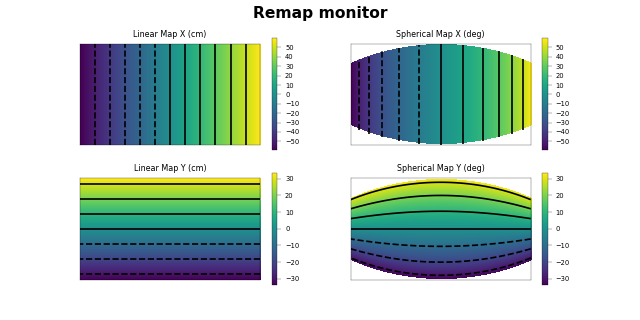

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  app.launch_new_instance()
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: The following kwargs were not used by contour: 'linewidth'


In [257]:
fig = plot_remap(cart_x, cart_y, warp_x, warp_y, cmap='viridis',
          resolution=resolution_ds) 
#, np.rad2deg(sphr_pointsTh), np.rad2deg(sphr_pointsPh))

# pl.savefig(os.path.join(sphr_dir, 'stimulus_v_perceived.svg'))

<IPython.core.display.Javascript object>


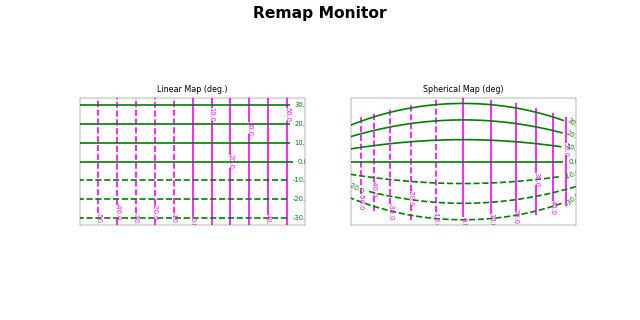

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: The following kwargs were not used by contour: 'linewidth'
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: The following kwargs were not used by contour: 'linewidth'


<IPython.core.display.Javascript object>


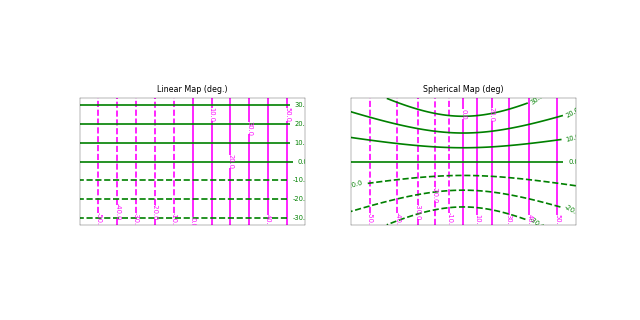

In [260]:
manual_x = [(i, 0) for i in np.arange(-20, 30, 10)]
manual_y = [( 0, i) for i in np.arange(-20, 30, 10)]

# levels_x = range(int(np.floor(np.nanmin(warp_x) / interval) * interval),
#             int((np.ceil(np.nanmax(warp_x) / interval) + 1) * interval), interval)
# manual_x = [(i, 10) for i in list(levels_x)[0:3]]

fig = plot_isolines(cart_x, cart_y, warp_x, warp_y, cmap='Spectral',
          resolution=resolution_ds, manual_x=None, manual_y=None,
                   rightside_up=True, interval=10, fontsize=6 )
#, np.rad2deg(sphr_pointsTh), np.rad2deg(sphr_pointsPh))
pl.savefig(os.path.join(sphr_dir, 'isolines_perceived.svg'))


corrected_x, corrected_y = np.rad2deg(sphr_x), np.rad2deg(sphr_y)
fig = plot_isolines(cart_x, cart_y, corrected_x, corrected_y, cmap='Spectral',
          resolution=resolution_ds, manual_x=None, manual_y=None,
          rightside_up=True, interval=10, fontsize=6 )
fig.suptitle('')
#, np.rad2deg(sphr_pointsTh), np.rad2deg(sphr_pointsPh))

pl.savefig(os.path.join(sphr_dir, 'isolines_corrected.svg'))

In [816]:
deg_y_ds = np.rad2deg(sphr_y_ds)

In [710]:
deg_y_ds.max()

27.346801004097372

In [711]:
cart_y_ds.min(), cart_y_ds.max()

(-24.836262344897445, 25.02344897442391)

# Load RF fits

In [14]:
# Load RF fits (R2 fit_thr=0.5)
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = aggr.add_rf_positions(rfdata)

N dpaths: 37, N unfit: 25
N datasets included: 62, N sessions excluded: 4


AttributeError: 'NoneType' object has no attribute 'reset_index'

In [221]:
cells_w_both = pd.concat([g for (va, dk, rid), g in \
                    rfdata.groupby(['visual_area', 'datakey', 'cell'])\
                   if 'rfs' in g['experiment'].values and \
                      'rfs10' in g['experiment'].values])
cells_w_both[['visual_area', 'datakey', 'cell']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,33,33
Lm,10,10
V1,200,200


In [1071]:
fovs_w_both = pd.concat([g for (va, dk), g in \
                    rfdata.groupby(['visual_area', 'datakey'])\
                   if 'rfs' in g['experiment'].values and \
                      'rfs10' in g['experiment'].values])
fovs_w_both[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,3
Lm,1
V1,4


In [1076]:
counts_w_both = fovs_w_both.groupby(['visual_area', 'datakey', 'experiment']).count()['cell'].reset_index()

In [1086]:
drop_repeats=True
counts_all = rfdata.groupby(['visual_area', 'datakey', 'experiment'])\
                .count()['cell'].reset_index()
counts_all = p3.split_datakey(counts_all)
unique_dsets = p3.select_best_fovs(counts_all, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
all_dkeys = list([tuple(k) for k in \
                  counts_all[['visual_area', 'datakey']].drop_duplicates().values])
final_dkeys = u_dkeys if drop_repeats else all_dkeys
dset_str = 'drop_repeats' if drop_repeats else 'all_dsets'

final_counts = pd.concat([g for (va, dk), g in counts_all.groupby(['visual_area', 'datakey'])\
          if (va, dk) in final_dkeys])
    

[V1] Animalid does not exist: JC078 


In [1090]:
rf_colors={'rfs': 'm', 'rfs10': 'c'}

<IPython.core.display.Javascript object>


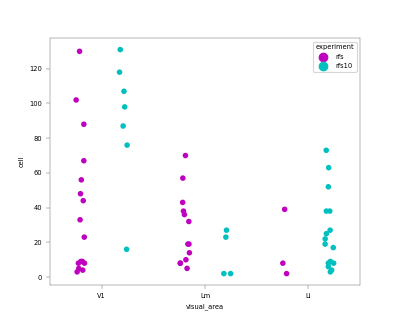

In [1097]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='cell', hue='experiment', data=counts_all,
             ax=ax, dodge=True, order=visual_areas,
             palette=rf_colors)
# sns.stripplot(x='visual_area', y='cell', hue='experiment', data=counts_all,
#              ax=ax, dodge=True, order=visual_areas,
#              palette=rf_colors)
tmpdir = os.path.join(aggregate_dir, 'receptive-fields',
                        'traces001__fit-2dgaus_dff-no-cutoff', 'rfs5_v_rfs10')
pl.savefig(os.path.join(tmpdir, 'counts_by_fov.svg'))

In [1096]:
rf_fit_desc

'fit-2dgaus_dff_sphr'

## Examples

In [24]:
if not os.path.exists(os.path.join(sphr_dir, 'examples')):
    os.makedirs(os.path.join(sphr_dir, 'examples'))


In [26]:
# va='V1'
# dk='20190616_JC097_fov1'
# rid=388
# rf_type='rfs'

# rf_type='rfs' if va in ['V1', 'Lm'] else 'rfs10'

# va = 'Li'
# dk = '20190614_JC091_fov1'
# rf_type = 'rfs10'
# rid = 211 #227 #32 #61

va = 'V1'
dk = '20190522_JC084_fov1'
rf_type = 'rfs'
rid = 93 #32 #61

session, animalid, fovn = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
do_spherical_correction=True
curr_rois = rfdata[(rfdata.visual_area==va) & (rfdata.datakey==dk) 
                 & (rfdata.experiment==rf_type)]['cell'].unique()
print(len(curr_rois))

NameError: name 'rfdata' is not defined

In [1178]:
fit_results, fit_params = rfutils.load_fit_results(animalid, session, fov,
                                experiment=rf_type, traceid=traceid,
                                response_type=response_type,
                                do_spherical_correction=False)

row_vals=fit_params['row_vals']
col_vals = fit_params['col_vals']


In [1179]:
ncols = len(fit_params['col_vals']) #21
nrows = len(fit_params['row_vals']) #11

In [1180]:
# Downsample screen (don't need full resolution)
downsampler=fit_params_sphr['downsample_factor']
resolution_ds = [int(i/downsampler) for i \
                 in fit_params['screen']['resolution'][::-1]]
print("Screen resolution (ds=%.1fx): [%i, %i]" \
      % (downsampler, resolution_ds[0], resolution_ds[1]))
# Linear coordinates
lin_x, lin_y = rfutils.get_lin_coords(resolution=resolution_ds)
# Spherical coordinates (Lin coords already in deg)
# cart_x, cart_y, sphr_x, sphr_y = rfutils.get_spherical_coords(cart_pointsX=lin_x, 
#                                         cart_pointsY=lin_y, cm_to_degrees=False)
# cart_x.shape
cart_x, cart_y, sphr_x, sphr_y = rfutils.get_spherical_coords(cart_pointsX=None, 
                                        cart_pointsY=None, cm_to_degrees=True,
                                        resolution=resolution_ds) 

Screen resolution (ds=3.0x): [360, 640]
(360, 640) (360, 640)


In [1181]:
# rid = 388 #32 #61
# rid = 388
rfmap = fit_results[rid]['data'].copy()
print(rfmap.shape)
# Upsample RF map to screen pixels
rfmap_orig = rfutils.resample_map(rfmap, cart_x, cart_y, 
                          row_vals=row_vals, col_vals=col_vals,
                          resolution=resolution_ds)
print(rfmap_orig.shape)
# Warp resampled RF map
rfmap_sphr = rfutils.warp_spherical(rfmap_orig, sphr_x, sphr_y, 
                        cart_x, cart_y, normalize_range=True, method='linear')
print(rfmap_sphr.shape)

(11, 21)
(360, 640)
(360, 640)


In [1182]:
# Trim
screen_bounds_pix = rfutils.get_screen_lim_pixels(cart_x, cart_y, 
                                    row_vals=row_vals, col_vals=col_vals)

rfmap_trim  = rfutils.trim_resampled_map(rfmap_orig, screen_bounds_pix)
rfmap_trim_sphr  = rfutils.trim_resampled_map(rfmap_sphr, screen_bounds_pix)
#rfmap_corrected[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge]
print(rfmap_trim.shape, rfmap_trim_sphr.shape)

# Downsample, so we don't have repeated values
rfmap_o = cv2.resize(rfmap_trim, (ncols, nrows))
rfmap_c = cv2.resize(rfmap_trim_sphr, (ncols, nrows))

(293, 561) (293, 561)


In [1183]:
sphr_y.max()

0.6069785045451996

<IPython.core.display.Javascript object>


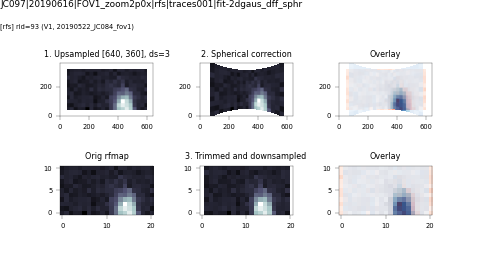

In [1184]:
fig, axn = pl.subplots(2, 3, figsize=(6,3.5))
ax = axn[0,0]
ax.imshow(rfmap_orig, cmap='bone')
ax.set_title('1. Upsampled [%i, %i], ds=%i' \
             % (resolution_ds[1], resolution_ds[0],downsampler))

ax = axn[0,1]
ax.imshow(rfmap_sphr, cmap='bone')
ax.set_title('2. Spherical correction')

ax = axn[0,2]
ax.imshow(rfmap_orig, alpha=0.7, cmap='Reds')
ax.imshow(rfmap_sphr, alpha=0.7, cmap='Blues')
ax.set_title('Overlay')

ax = axn[1,0]
ax.imshow(rfmap, cmap='bone')
ax.set_title('Orig rfmap')

ax = axn[1,1]
ax.imshow(rfmap_c, cmap='bone')
ax.set_title('3. Trimmed and downsampled')

ax = axn[1,2]
ax.imshow(rfmap, alpha=0.7, cmap='Reds')
ax.imshow(rfmap_c, alpha=0.7, cmap='Blues')
ax.set_title('Overlay')

for ax in axn.flat:
    ax.set_aspect('equal')
    ax.invert_yaxis()
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, bottom=0.2)
pplot.label_figure(fig, data_id)
fig.text(0., 0.9, '[%s] rid=%i (%s, %s)' % (rf_type, rid, va, dk))

figname = 'steps_%s_%s_rid%i_%s' % (va, dk, rid, rf_type)
pl.savefig(os.path.join(sphr_dir, 'examples', '%s.svg' % figname))

## Visualize all RFs for FOV

In [1185]:
fit_params['rfdir']

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_b78b04_traces001_5c60f6_traces001_7a5ecd_traces001_c80ac8_traces001_656bda_traces001_f17a03/receptive_fields/fit-2dgaus_dff-no-cutoff'

In [1176]:
# Load original rfmaps
rfmaps_arr = rfutils.load_rfmap_array(fit_params['rfdir'], 
                                      do_spherical_correction=False)
rfmaps_arr.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [1164]:
ds_factor=3
col_vals = fit_params['col_vals']
row_vals = fit_params['row_vals']
# Downsample screen resolution
resolution_ds = [int(i/ds_factor) for i in \
                 fit_params['screen']['resolution'][::-1]]
# Get linear coordinates in degrees (downsampled)
# lin_x, lin_y = get_lin_coords(resolution=resolution_ds, cm_to_deg=True)
print("Screen res (ds=%ix): [%i, %i]" % (ds_factor, resolution_ds[0], resolution_ds[1]))
# Get Spherical coordinate mapping
cart_x, cart_y, sphr_th, sphr_ph = rfutils.get_spherical_coords(
                                    cart_pointsX=None, cart_pointsY=None,
                                    cm_to_degrees=True, resolution=resolution_ds) # already in deg

args=(cart_x, cart_y, sphr_th, sphr_ph, resolution_ds, row_vals, col_vals,)

Screen res (ds=3x): [360, 640]
(360, 640) (360, 640)


In [1165]:
do_spherical_correction

True

In [1166]:
run = rf_type
print(run)
do_spherical_correction=True
# -----------------------------------------------------------------------------
# rf_param_str = 'fit-2dgaus_%s-no-cutoff' % (response_type) 
run_name = run.split('_')[1] if 'combined' in run else run
rfdir, fit_desc = rfutils.create_rf_dir(datakey,
                                'combined_%s_static' % run_name, traceid=traceid,
                                response_type=response_type,
                                do_spherical_correction=do_spherical_correction, fit_thr=fit_thr)
fit_params = rfutils.get_fit_params(datakey, run=run_name,
                                traceid=traceid, response_type=response_type,
                                do_spherical_correction=do_spherical_correction)
# Get data source
traceid_dir = rfdir.split('/receptive_fields/')[0]
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')
data_id = '|'.join([animalid, session, fov, run, traceid, fit_desc])
if not os.path.exists(data_fpath):
    # Realign traces
    print("*****corrected offset unfound, ABORT*****")
    print("%s | %s | %s | %s | %s" % (animalid, session, fov, run, traceid))
    # aggregate_experiment_runs(animalid, session, fov, run_name, traceid=traceid)
    # print("*****corrected offsets!*****")

rfs


In [1167]:
print(fit_params['rfdir'])

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_e0b0a8_traces001_dd504a_traces001_0e6f9a_traces001_1c5b41_traces001_5483ef_traces001_9f6c47/receptive_fields/fit-2dgaus_dff_sphr


In [1162]:
print(len(curr_rois))
rfmaps_arr = rfutils.sphr_correct_maps(rfmaps_arr[curr_rois], ds_factor=3, 
                                        fit_params=fit_params)
rfutils.save_rfmap_array(rfmaps_sphr, fit_params['rfdir'])
    

102
Screen res (ds=3x): [360, 640]
(360, 640) (360, 640)


KeyboardInterrupt: 

In [1168]:
fit_params['rfdir']

'/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_e0b0a8_traces001_dd504a_traces001_0e6f9a_traces001_1c5b41_traces001_5483ef_traces001_9f6c47/receptive_fields/fit-2dgaus_dff_sphr'

In [1170]:
fit_results_sphr, fit_params_sphr = rfutils.fit_rfs(rfmaps_arr, response_type=response_type,
                            do_spherical_correction=do_spherical_correction,
                            fit_params=fit_params, data_identifier=data_id)

@@@ doing rf fits @@@


AttributeError: 'NoneType' object has no attribute 'columns'

In [932]:
print(data_id)

JC091|20190614|FOV1_zoom2p0x|rfs10|traces001|fit-2dgaus_dff_sphr


In [1196]:
print(animalid, session, fov, rf_type)
fit_results, fit_params = rfutils.load_fit_results(animalid, session, fov,
                                     experiment=rf_type, traceid=traceid,
                                     response_type=response_type,
                                     do_spherical_correction=False)


JC084 20190522 FOV1_zoom2p0x rfs


In [1197]:

fit_results_sphr, fit_params_sphr = rfutils.load_fit_results(animalid, session, fov,
                                     experiment=rf_type, traceid=traceid,
                                     response_type=response_type,
                                     do_spherical_correction=True)

In [1198]:
fitdf_orig = rfutils.rfits_to_df(fit_results, fit_params=fit_params,
                               row_vals=row_vals, col_vals=col_vals, spherical=False)
fitdf_sphr = rfutils.rfits_to_df(fit_results_sphr, fit_params=fit_params_sphr,
                               row_vals=row_vals, col_vals=col_vals, spherical=True)
pass_rois_orig = fitdf_orig[fitdf_orig['r2']>0.5].dropna().index.tolist()
pass_rois_sphr = fitdf_sphr[fitdf_sphr['r2']>0.5].dropna().index.tolist()

print("N fit (orig): %i" % len(pass_rois_orig))
print("N fit (warp): %i" % len(pass_rois_sphr))

pass_rois_both = np.intersect1d(pass_rois_orig, pass_rois_sphr)
len(pass_rois_both)

Screen res (ds=3x): [360, 640]
N fit (orig): 134
N fit (warp): 97


96

In [1199]:
rid

93

In [1190]:

# fig = rfutils.plot_top_rfs(fitdf_sphr, fit_params_sphr, fit_roi_list=roi_list)
# pplot.label_figure(fig, data_id)
# figname = 'top%i_fit_thr_%.2f_%s_ellipse__p3' % (len(fit_roi_list), fit_thr, fit_desc)
# pl.savefig(os.path.join(fit_params_sphr['rfdir'], '%s.png' % figname))
# print(figname)


In [ ]:
#rid = 211 #388 #211
rid in pass_rois_both
rid

In [1192]:
screen = p3.get_screen_dims()

In [1145]:
sdf = p3.get_stimuli(dk, rf_type)

<IPython.core.display.Javascript object>


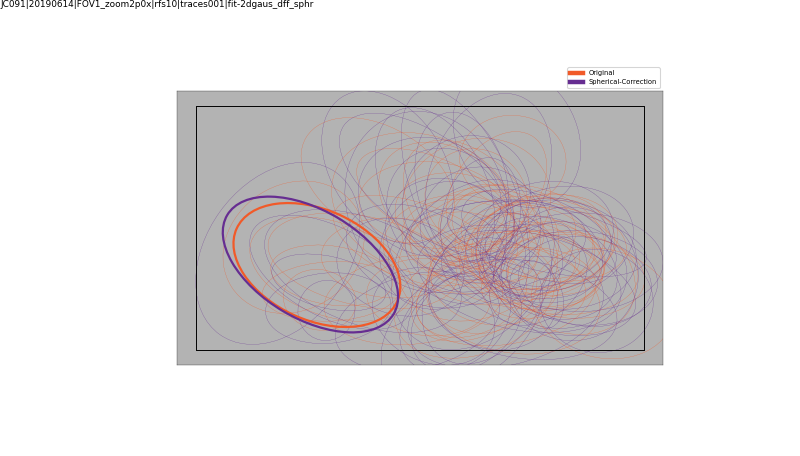

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxx_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


In [1146]:
c1 = '#f15a29' #'k'
c2 =  '#662d91' #'w'
fig, ax = pl.subplots( figsize=(10, 5.7))
fig.patch.set_visible(False) #(False) #('off')

example_roi_list=[rid]
other_rois = [r for r in pass_rois_both if r not in example_roi_list]

ax = rfutils.plot_rfs_to_screen_pretty(fitdf_orig, sdf, screen, 
                               sigma_scale=1, #fit_params['sigma_scale'],
                               fit_roi_list=pass_rois_both, ax=ax, 
                               roi_colors=[c1]*len(other_rois), ellipse_lw=0.2)

other_rois = [r for r in pass_rois_both if r not in example_roi_list]
ax = rfutils.plot_rfs_to_screen_pretty(fitdf_sphr, sdf, screen, 
                               sigma_scale=1, #fit_params['sigma_scale'],
                               fit_roi_list=pass_rois_both, ax=ax, 
                               roi_colors=[c2]*len(other_rois), ellipse_lw=0.2)

ax = rfutils.plot_rfs_to_screen_pretty(fitdf_orig, sdf, screen, 
                               sigma_scale=1, #fit_params['sigma_scale'],
                               fit_roi_list=example_roi_list, ax=ax, 
                               roi_colors=[c1]*len(example_roi_list), ellipse_lw=2)
ax = rfutils.plot_rfs_to_screen_pretty(fitdf_sphr, sdf, screen, 
                               sigma_scale=1, #fit_params['sigma_scale'],
                               fit_roi_list=example_roi_list, ax=ax, 
                               roi_colors=[c2]*len(example_roi_list), ellipse_lw=2)

ax.patch.set_color([0.7]*3)
ax.patch.set_alpha(1)
ax.set_aspect('equal')

custom_lines = [mpl.lines.Line2D([0], [0], color=c1, lw=4),
                mpl.lines.Line2D([0], [0], color=c2, lw=4)]
ax.legend(custom_lines, ['Original', 'Spherical-Correction'],
          bbox_to_anchor=(1,1), loc='lower right')


pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = '%s__screen_rfs__%s_%s_rid%i__p3' % (rf_type, va, dk, rid)
pl.savefig(os.path.join(sphr_dir, 'examples', '%s.svg' % (figname)), 
           bboxx_inches='tight')

In [1040]:
va, dk

('Li', '20190614_JC091_fov1')

In [1136]:
sort_by_fit = fitdf_orig.loc[pass_rois_both]\
                .sort_values(by='r2', ascending=False).index.tolist()
plot_rois = sort_by_fit[0:30]
print([i for i in plot_rois if i not in fitdf_orig.index.tolist()])
print([i for i in plot_rois if i not in fitdf_sphr.index.tolist()])


[]
[]


<IPython.core.display.Javascript object>


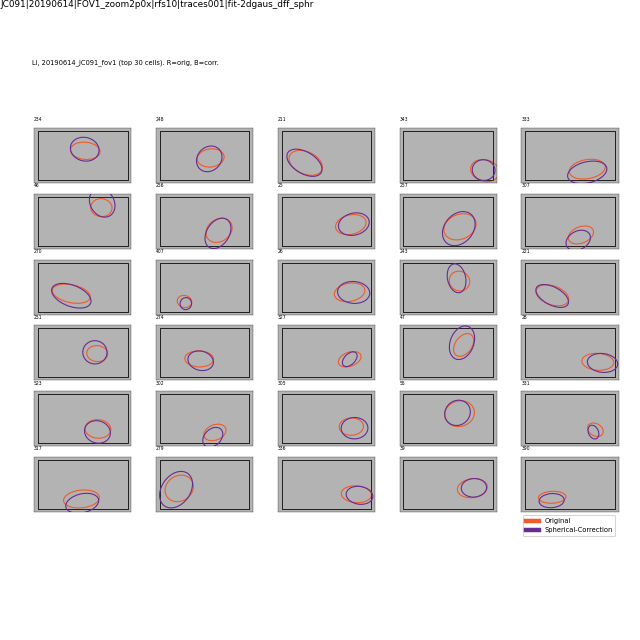

rfs10__top30_compare_Li_20190614_JC091_fov1__p3


In [1142]:
plot_rois = sort_by_fit[0:30]
fig, axn = pl.subplots(6, 5, figsize=(8,8))
fig.patch.set_visible(False) #(False) #('off')

for ax, rid in zip(axn.flat, plot_rois):
    ax = rfutils.plot_rfs_to_screen_pretty(fitdf_orig, sdf, screen, 
                                   sigma_scale=1, #fit_params['sigma_scale'],
                                   fit_roi_list=[rid], ax=ax, 
                                   roi_colors=[c1],
                                   ellipse_lw=1)
    ax = rfutils.plot_rfs_to_screen_pretty(fitdf_sphr, sdf, screen, 
                                   sigma_scale=1, #fit_params['sigma_scale'],
                                   fit_roi_list=[rid], ax=ax, 
                                   roi_colors=[c2],
                                    ellipse_lw=1)
    ax.set_title(rid, loc='left', fontsize=4)
for ax in axn.flat:
    ax.patch.set_color([0.7]*3)
    ax.patch.set_alpha(1)
    ax.set_aspect('equal')

custom_lines = [mpl.lines.Line2D([0], [0], color=c1, lw=4),
                mpl.lines.Line2D([0], [0], color=c2, lw=4)]
axn.flat[-1].legend(custom_lines, ['Original', 'Spherical-Correction'],
          bbox_to_anchor=(1,0), loc='upper right')

fig.text(0.05, 0.9, '%s, %s (top %i cells). R=orig, B=corr.' % (va, dk, len(plot_rois)))
    
pl.subplots_adjust(left=0.05, right=0.97, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = '%s__top%i_compare_%s_%s__p3' % (rf_type,len(plot_rois), va,dk)
pl.savefig(os.path.join(sphr_dir, 'examples', '%s.svg'%figname))
print(figname)

In [703]:
cells_w_both['datakey'].unique()

array(['20190602_JC091_fov1', '20191017_JC113_fov1',
       '20190618_JC097_fov1', '20190613_JC097_fov1',
       '20190616_JC097_fov1', '20190622_JC085_fov1',
       '20191006_JC110_fov1'], dtype=object)

In [ ]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

response_type='dff'
responsive_test='ROC'
overlap_thr=None
trial_epoch = 'plushalf'
traceid = 'traces001'

responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap%.2f' % overlap_thr

fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
        % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)

datafile = os.path.join(aggregate_dir, 'data-stats', 'tmp_data', '%s.pkl' % fname)
with open(datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
D.keys()

In [ ]:
def get_dsets_with_max_rfs(rf_dsets, assigned_cells):

    # Load all RF data
    from pipeline.python.classifications import rf_utils as rfutils
    all_rfdfs = rfutils.load_aggregate_rfs(rf_dsets)
    all_rfs = get_rfdata(assigned_cells, all_rfdfs, verbose=False, average_repeats=True)

    best_dfs = get_dsets_with_most_cells(all_rfs) #, assigned_cells)

    return best_dfs

